# Rossmann Stores Sales Forecasting 

## Planeamento da Solução (IOT)

***

## Workspace Setup

### Library Imports

In [1]:
import pandas as pd
import seaborn as sns

import warnings
import re
import math
import datetime

from matplotlib import pyplot as plt
from IPython.core.display import display,HTML,Image

/tmp/ipykernel_15926/3271539233.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML,Image


### Notebook Settings

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    
    pd.options.display.max_columns = 200
    pd.options.display.max_rows = 700
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
    warnings.filterwarnings("ignore")

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Auxiliar Functions

#### EDA functions

##### Summary Statistics

In [4]:
# Summary Statistical functions

def descriptive_stats(data: pd.DataFrame):
    
    """ A summary statistics with a few
    more statistics metrics like skew and
    kurtosis.
    
    It is meant to help do a descriptive
    analysis.
    
    Parameters
    ----------
    data: pd.DataFrame

    Returns
    ----------
    descriptive_statistics: pd.DataFrame
    """
    
    mean = pd.DataFrame(data.mean())
    std = pd.DataFrame(data.std())
    median = pd.DataFrame(data.median())

    q1,q3 = pd.DataFrame(data.quantile(0.25)), pd.DataFrame(data.quantile(0.75))
    
    iqr = q3[0.75] - q1[0.25]
    q0,q4 = q1[0.25] - (1.5*iqr), q3[0.75] + (1.5*iqr)

    maximum = pd.DataFrame(data.max())
    minimum = pd.DataFrame(data.min())

    skew = pd.DataFrame(data.skew())
    kurtosis = pd.DataFrame(data.kurtosis())

    descriptive_statistics = pd.concat([mean,std,minimum,q0,q1,median,q3,q4,maximum,skew,kurtosis],axis=1)
    
    descriptive_statistics.columns = ['mean','std','minimum','q0','q1','median','q3','q4','maximum','skew','kurtosis']
    
    return descriptive_statistics

def group_descriptive_stats(data: pd.DataFrame, agg_feature: str, info_feature: str):
    
    """ A summary statistics for an aggregation
    of a specific feature category and get a few
    more statistics metrics like skew and
    kurtosis.
    
    It is meant to help do a descriptive
    analysis.
    
    Parameters
    ----------
    data: pd.DataFrame
    agg_feature: str
    info_feature: str

    Returns
    ----------
    grouped_descriptive_statistics: pd.DataFrame
    """
    
    grouped_data = data[[agg_feature,info_feature]].groupby(agg_feature)
    
    mean = grouped_data.mean()
    std = grouped_data.std()
    median = grouped_data.median()

    q1,q3 = grouped_data.quantile(0.25), grouped_data.quantile(0.75)
    
    iqr = q3 - q1
    q0,q4 = q1 - (1.5*iqr), q3 + (1.5*iqr)

    maximum = grouped_data.max()
    minimum = grouped_data.min()

    skew = grouped_data.skew()
    kurtosis = grouped_data.apply(pd.DataFrame.kurt).drop(agg_feature,axis=1)
    
    grouped_descriptive_statistics = pd.concat([mean,std,minimum,q0,q1,median,q3,q4,maximum,skew,kurtosis],axis=1)
    
    grouped_descriptive_statistics.columns = ['mean','std','minimum','q0','q1','median','q3','q4','maximum','skew','kurtosis']
    
    return grouped_descriptive_statistics

def select_num_attr(data: pd.DataFrame):
    
    """ Get only the numeric part
    of a DataFrame.
    
    Parameters
    ----------
    data: pd.DataFrame

    Returns
    ----------
    numeric_data: pd.DataFrame
    """
    
    return data.select_dtypes(include=['int64', 'float64'])

## 0. Data Collection and Integration

### 0.1 Loading Data

In [5]:
!ls ../data

sample_submission.csv  store.csv  test.csv  train.csv


In [6]:
sales_df = pd.read_csv('../data/train.csv')
stores_df = pd.read_csv('../data/store.csv')

### 0.2 Merge Sales and Store data

In [7]:
stores_sales_df = pd.merge(sales_df,stores_df, how='left', on='Store')

### 0.3 General Info

In [8]:
stores_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [9]:
stores_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [10]:
stores_sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1014567.00,693861.00,693861.00,1017209.00,509178.00,509178.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18,5430.09,7.22,2008.69,0.50,23.27,2011.75
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38,7715.32,3.21,5.99,0.50,14.10,1.66
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00,2330.00,8.00,2010.00,1.00,22.00,2012.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


### 0.4 Rename Columns

In [11]:
columns = list(stores_sales_df.columns)

cols_single_words = [re.findall("[A-Z][^A-Z]*", column) for column in columns]

cols_lowercase_words = [list(map(lambda x: x.lower(),column)) for column in cols_single_words]

cols_snakecase = ['_'.join(column) for column in cols_lowercase_words]

stores_sales_df.columns = cols_snakecase

stores_sales_df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 0.5 Change Data Types 

In [12]:
stores_sales_df['date'] = pd.to_datetime(stores_sales_df['date'])

## 1. Exploratory Data Analysis

In [13]:
stores_sales_df_eda = stores_sales_df.copy(deep=True)

### 1.1 Data Dimensionality

In [14]:
print('Number of Rows:{}'.format(stores_sales_df_eda.shape[0]))
print('Number of Columns {}'.format(stores_sales_df_eda.shape[1]))

Number of Rows:1017209
Number of Columns 18


In [15]:
print(f'Number of Unique Stores: {len(stores_sales_df_eda.store.unique())}')

Number of Unique Stores: 1115


### 1.2 Attributes Names and Description

**Store (categorical)** - a unique Id for each store

**Assortment (categorical)** - describes an assortment level: a = basic, b = extra, c = extended

**Competition Distance (ordered quantitative ratio)** - distance in meters to the nearest competitor store

**DayOfWeek (ordered ordinal)** - the day of the week the record was taken

**Date (ordered quantitative continuous)** - the current date which an instance was recorded

**Sales (ordered ordinal)** - the turnover for any given day

**Customers (ordered ordinal)** - the number of customers on a given day

**Open (categorical binary asymmetric)** - an indicator for whether the store was open: 0 = closed, 1 = open

**Promo (categorical binary asymmetric)** - indicates whether a store is running a promo on that day

**StateHoliday (categorical binary asymmetric)** - indicates if there's a state on that day.

**SchoolHoliday (categorical binary asymmetric)** - indicates if the (Store, Date) was affected by the closure of public schools

### 1.3 Attributes Descriptive Statistics (Summary Statistics)

#### Numerical attributes

In [16]:
num_attr_df = select_num_attr(stores_sales_df_eda)

In [17]:
descriptive_stats(num_attr_df)

,mean,std,minimum,q0,q1,median,q3,q4,maximum,skew,kurtosis
store,558.43,321.91,1.00,-557.00,280.00,558.00,838.00,1675.00,1115.00,-0.00,-1.20
day_of_week,4.00,2.00,1.00,-4.00,2.00,4.00,6.00,12.00,7.00,0.00,-1.25
sales,5773.82,3849.93,0.00,-2466.50,3727.00,5744.00,7856.00,14049.50,41551.00,0.64,1.78
customers,633.15,464.41,0.00,-243.00,405.00,609.00,837.00,1485.00,7388.00,1.60,7.09
open,0.83,0.38,0.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.76,1.09
promo,0.38,0.49,0.00,-1.50,0.00,0.00,1.00,2.50,1.00,0.49,-1.76
school_holiday,0.18,0.38,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.68,0.82
competition_distance,5430.09,7715.32,20.00,-8560.00,710.00,2330.00,6890.00,16160.00,75860.00,2.93,13.00
competition_open_since_month,7.22,3.21,1.00,-5.00,4.00,8.00,10.00,19.00,12.00,-0.17,-1.25
competition_open_since_year,2008.69,5.99,1900.00,1995.50,2006.00,2010.00,2013.00,2023.50,2015.00,-7.54,121.93


In [18]:
group_descriptive_stats(num_attr_df,'store','sales')

,mean,std,minimum,q0,q1,median,q3,q4,maximum,skew,kurtosis
store,,,,,,,,,,,
1,3945.70,2015.42,0,1140.62,3588.25,4373.50,5220.00,7667.62,9528,-0.88,0.15
2,4122.99,2363.63,0,-1689.88,2806.75,4395.50,5804.50,10301.12,10682,-0.31,-0.38
3,5741.25,3298.78,0,-1610.38,4247.50,5892.00,8152.75,14010.62,15689,-0.33,-0.39
4,8021.77,4012.59,0,2884.75,7322.50,9062.00,10281.00,14718.75,17412,-0.96,0.25
5,3867.11,2389.61,0,-3061.38,2027.00,4180.00,5419.25,10507.62,11692,-0.13,-0.56
...,...,...,...,...,...,...,...,...,...,...,...
1111,4342.97,2500.01,0,-457.25,3316.75,4614.00,5832.75,9606.75,12492,-0.26,-0.17
1112,8465.28,4919.93,0,83.88,6780.25,8707.00,11244.50,17940.88,25165,-0.10,0.17
1113,5516.18,2811.39,0,2174.50,5122.00,6018.50,7087.00,10034.50,16115,-0.77,0.48


##### Statistical Interpretation 

Interpret each attribute central tendency, dispersion:

**sales** - I can say that daily sales can range between 0$ and 41551$ (considering all stores). Then I can conclude that 25\% of the daily sales records (considering all stores) has a total equal or less than 3727$, up t0 50\%  of the records got 5744\% of dailyt sales or less, and 75\% makes at least 7856\%. Comparing the mean and median I can conclude that the sales distribution is near to a normal, since the mean minus the median is equal to (5773.82 - 5744.00 = 29.82) and the skew is almost 0. The kurtosis and standard deviation points out that the sales dispersion is not high, so it concentrates a lot around the median, and since the kurtosis is near to 3 but below, it means that its almost a dispersion of a normal distribution and it confirms that it has a light tailed distribution, i.e. it hasn't many outliers.

**customers** -

#### Categorical Attributes

In [19]:
cat_attr_df = stores_sales_df_eda.select_dtypes(exclude='number')

cat_attr_df.apply(lambda x: x.unique().shape[0])

date              942
state_holiday       5
store_type          4
assortment          3
promo_interval      4
dtype: int64

In [20]:
cat_attr_df.state_holiday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

[Text(0, 0, 'Jan,Apr,Jul,Oct'),
 Text(1, 0, 'Mar,Jun,Sept,Dec'),
 Text(2, 0, 'Feb,May,Aug,Nov')]

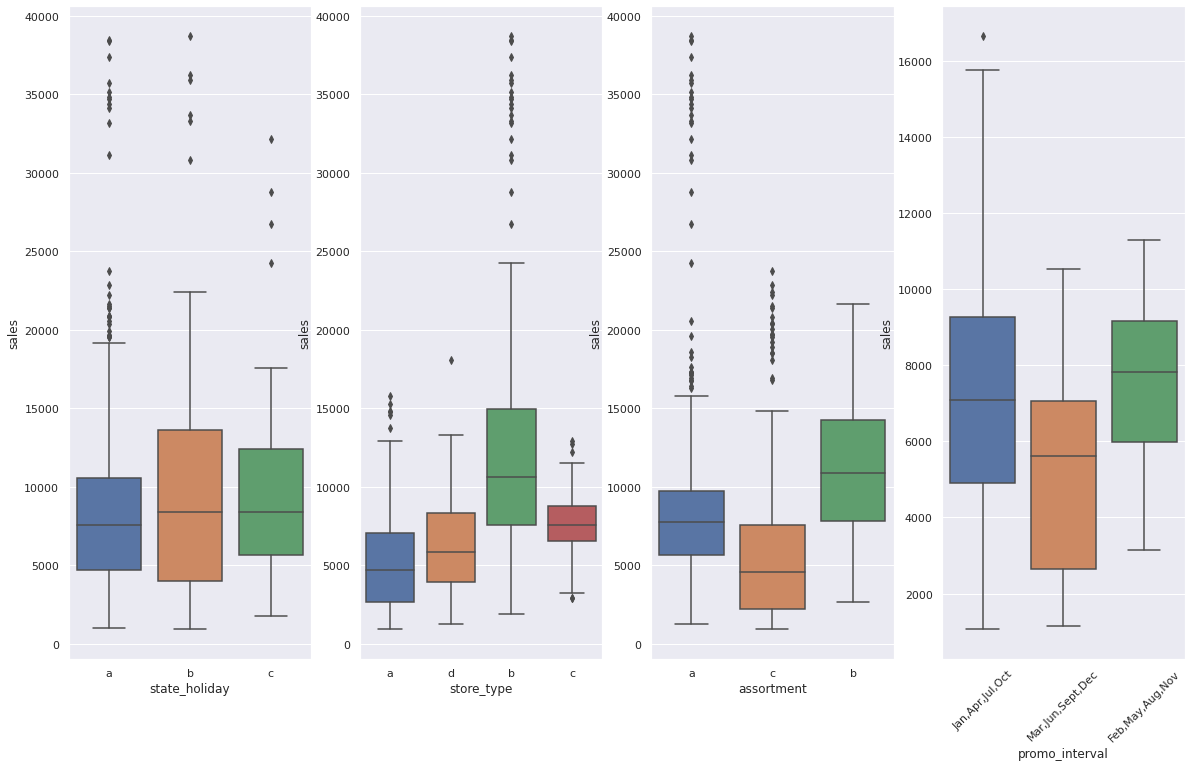

In [21]:
# to get a better interpretation of selling distribution and boxplot I must filter the daily records from when the store was closed during the week and the state holidays
opened_days_records = stores_sales_df_eda.loc[(stores_sales_df_eda.state_holiday != '0') & (stores_sales_df_eda.state_holiday != 0) & (stores_sales_df_eda.sales > 0)] 

plt.subplot(1, 4, 1)
ax1 = sns.boxplot(x='state_holiday', y='sales', data=opened_days_records)

plt.subplot(1, 4, 2)
ax2 = sns.boxplot(x='store_type', y='sales', data=opened_days_records)

plt.subplot(1, 4, 3)
ax3 = sns.boxplot(x='assortment', y='sales', data=opened_days_records)

plt.subplot(1, 4, 4)
ax4 = sns.boxplot(x='promo_interval', y='sales', data=opened_days_records)
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=45)

##### Statistical Interpretation 

Interpret each attribute central tendency, dispersion:

**store_type** - 25% of the stores of store_type b have already higher daily sales than the other ones.

**assortment** - 25% of the stores of assortment type b have already higher daily sales than the other assortments, so extra products seems to have more purchases or the value can be higher (confirm)

### 1.4 Identify missing values and Duplicated records

#### Missing Values

In [22]:
stores_sales_df_eda.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [23]:
(stores_sales_df_eda.isna().sum()/len(stores_sales_df_eda))*100

store                           0.00
day_of_week                     0.00
date                            0.00
sales                           0.00
customers                       0.00
open                            0.00
promo                           0.00
state_holiday                   0.00
school_holiday                  0.00
store_type                      0.00
assortment                      0.00
competition_distance            0.26
competition_open_since_month   31.79
competition_open_since_year    31.79
promo2                          0.00
promo2_since_week              49.94
promo2_since_year              49.94
promo_interval                 49.94
dtype: float64

##### Get missing values per store

To evaluate which strategy to use on missing values. Since the missing values may be originated only by some stores out of the 1115 stores, which could be irrelevant and this records could be discarded. 

Or in the case it is a generalized presence on all stores data attributes, I can then identify if the percentage of missing values is very high on some specific attributeS, and this attributes may not be relevant anymore. 

If the percentage is not so high we can apply an imputation or replacement strategy.

In [24]:
store_agg = stores_sales_df_eda.groupby(by='store')

count_na = store_agg.count()

count_na

,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
store,,,,,,,,,,,,,,,,,
1,942,942,942,942,942,942,942,942,942,942,942,942,942,942,0,0,0
2,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942
3,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942
4,942,942,942,942,942,942,942,942,942,942,942,942,942,942,0,0,0
5,942,942,942,942,942,942,942,942,942,942,942,942,942,942,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942
1112,942,942,942,942,942,942,942,942,942,942,942,942,942,942,0,0,0
1113,942,942,942,942,942,942,942,942,942,942,942,0,0,942,0,0,0


In [25]:
# [count_na.iloc[i_store] for i_store in range(len(count_na))]

perc_na_per_store = count_na.apply(lambda x: (x/x[1])*100)

stores_na_filter = [any((perc_na_per_store.iloc[i_store].isna()) | (perc_na_per_store.iloc[i_store] < 100)) for i_store in range(len(perc_na_per_store))]

perc_na_per_store.loc[stores_na_filter]

,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
store,,,,,,,,,,,,,,,,,
1,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
4,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
5,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
6,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
7,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
1112,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
1113,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,100.00,NaN,NaN,NaN


###### Conclusions

Since it is a generalized presence of missing values over almost all stores, those cannot be specifically removed, but according to percentage of each attribute we can choose if it is not worth it continuing with those attributes. Like the promo2 columns could be dropped since almost half of the records are missing.

The other attributes can be filled with some preliminary value on the 1st CRISP cycle, only to allow solution delivery process, and then optimize what could be the best imputation strategy.

#### Missing Records

#### Duplicated Records

### 1.5 Data Inconsistency

There are negative days on competition_since, telling that there are some daily sales records that register a future date on the opening of a competitor store (it could have been from the imputation) 

There are negative days on promo_time_week, telling that there are some daily sales records that register a future date of a promotion (it could have been from the imputation)

### 1.10 Define Business Data Assumptions and Hypothesis

#### 1.10.1 Features Mindmap

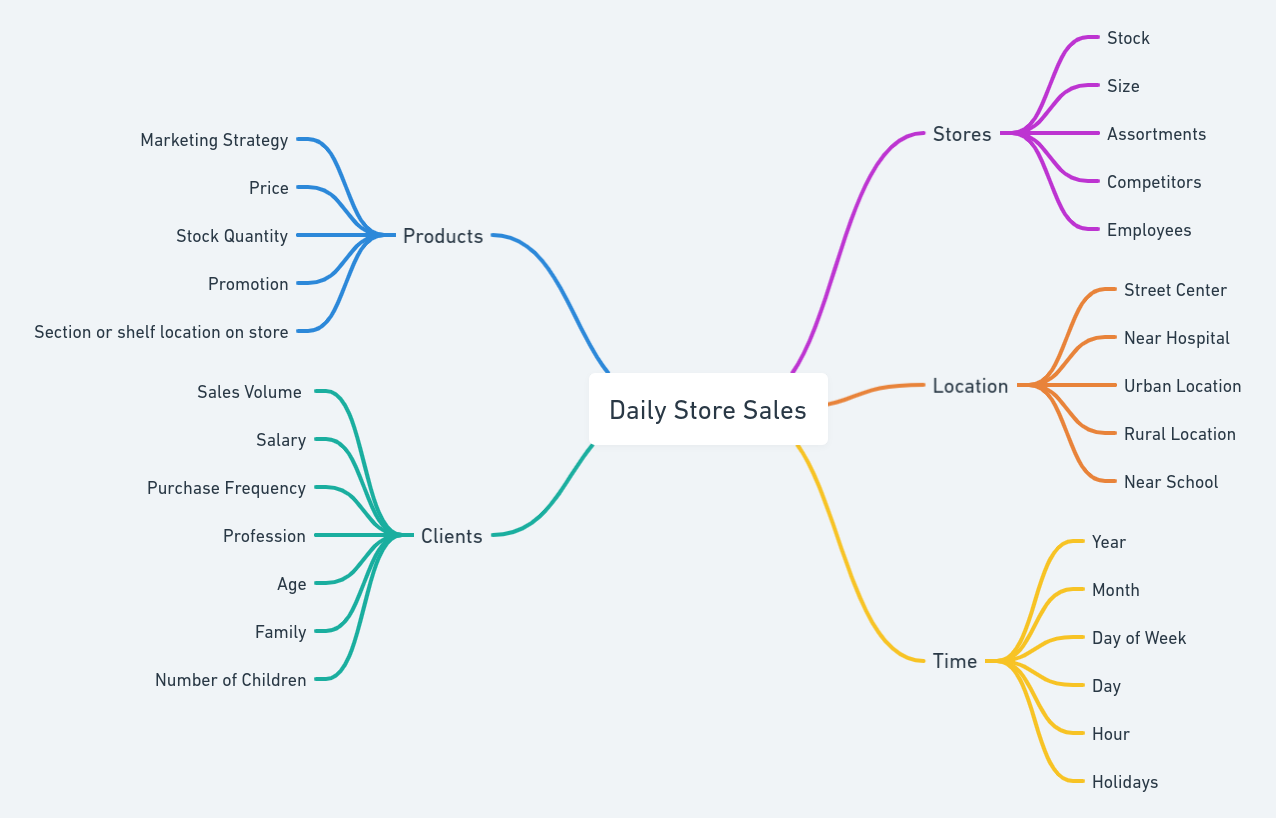

In [26]:
Image('../images/rossmann-features-mindmap.png')

#### 1.10.2 Hypothesis

##### Stores hypothesis

**1.** Stores with more employees should be selling more.

**2.** Stores with more stock should be selling more.

**3.** Stores with higher size should be selling more.

**4.** Stores that have a bigger assortment should be selling more

**5.** Stores with closer competitors should be selling less.

**6.** Stores with competitors opened for a longer time period should be selling more.

##### Products hypothesis

**1.** Stores that invest more on new Marketing strategies should be selling more.

**2.** Stores that expose more the products on showcases should be selling more.

**3.** Stores that sell cheaper products should be selling more.

**4.** Stores with promotions applied for longer period of time should be selling more.

**5.** Stores with more consecutive promotions periods should be selling more.

##### Time Hypothesis

**1.** Stores that are closed on a lot of public holidays should be selling less.

**2.** Stores that open on the first 6 months should be selling more.

**3.** Stores that open on weekends should be selling more.

**4.** Stores are selling more in the beginning of the month instead of the end of the month.

**5.** Stores should be selling more on the second semester.

**6.** Stores should be selling more Year over Year.

##### Final Hypothesis (feasible ones)

**1.** Stores with closer competitors should be selling less.

**2.** Stores with competitors opened for a longer time period should be selling more.

**3.** Stores are selling more in the beginning of the month instead of the end of the month.

**4.** Stores with promotions applied for longer period of time should be selling more.

**5.** Stores with more consecutive promotions periods should be selling more.

**6.** Stores that are closed on a lot of public holidays should be selling less.

**7.** Stores that open on the first 6 months should be selling more.

**8.** Stores that open on weekends should be selling more.

**9.** Stores are selling more in the beginning of the month instead of the end of the month.

**10.** Stores should be selling more on the second semester.

**11.** Stores should be selling more Year over Year.

#### 1.10.3 Attributes Usefulness for the task

**competition_open_since_month** - it can be important to analyze how much impact the sales could have been suffering since a competition store has opened nearby

## 2. Data Pre-processing

In [27]:
stores_sales_df_preprocess = stores_sales_df_eda.copy(deep=True)

### 2.1 Feature Imputation

#### Filling missing values

**Filling NA strategy:**

- **competition_distance** - as the maximum value is 75860.00 a missing value can be replaced by a higher value representing that this store may not have a competitor 
- **competition_open_since_month** - assuming that we have a competitor by looking at the competition distance on each store and check if it is equal or smaller than the original maximum competition distance, I can assume that the competitor is opened since the current daily sales record month
- **competition_open_since_year** - assuming that we have a competitor by looking at the competition distance on each store and check if it is equal or smaller than the original maximum competition distance, I can assume that the competitor is opened since the current daily sales record year

- **promo2_since_week** - assuming that there is really a promotion applied on the store on the current daily sales record, by looking at the binary variable promo2, I can assume that the promotion is applied since the week of this record
- **promo2_since_year** - assuming that there is really a promotion applied on the store on the current daily sales record, by looking at the binary variable promo2, I can assume that the promotion is applied since the year of this record
- **promo_interval** - assuming that it could have been a failure on recording sales procedure, the month interval that the promo is applied it can be replaced by the month of the current daily sales record, only if the promo2 variable is 1. 

In [28]:
aux_df = stores_sales_df_preprocess.copy(deep=True)

# competition_distance
orig_max_competition_dist = aux_df.competition_distance.max()
stores_sales_df_preprocess.loc[aux_df.competition_distance.isna(),'competition_distance'] = 200000.00

# competition_open_since_month
aux_df.competition_open_since_month = aux_df[['date',
                                              'competition_distance',
                                              'competition_open_since_month']].apply(lambda x: x[0].month if (math.isnan(x[2])) &\
                                                                                                            (x[1] <= orig_max_competition_dist)
                                                                                          else x[2],axis=1)
# competition_open_since_year
aux_df.competition_open_since_year = aux_df[['date',
                                             'competition_distance',
                                             'competition_open_since_year']].apply(lambda x: x[0].year if (math.isnan(x[2])) &\
                                                                                                         (x[1] <= orig_max_competition_dist)
                                                                                        else x[2],axis=1)

# promo2_since_week
aux_df.promo2_since_week = aux_df[['date',
                                   'promo2',
                                   'promo2_since_week']].apply(lambda x: x[0].week if (math.isnan(x[2])) & \
                                                                                                 (x[1] == 1)
                                                                    else x[2],axis=1)

# promo2_since_year 
aux_df.promo2_since_year = aux_df[['date',
                                   'promo2',
                                   'promo2_since_year']].apply(lambda x: x[0].year if (math.isnan(x[2])) & \
                                                                                                 (x[1] == 1)
                                                                    else x[2],axis=1)
# promo_interval
month_dict = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
aux_df.loc[aux_df.promo_interval.isna(),'promo_interval'] = aux_df.date.dt.month.map( month_dict )

aux_df.loc[aux_df.promo2 == 0,'promo_interval'] = np.NaN

In [29]:
aux_df.promo_interval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [30]:
aux_df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month      2642
competition_open_since_year       2642
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

###### Conclusion

By filling the competition_open_since_month and competition_open_since_year, if the competition_distance wasn't smaller or equal to the original one before the imputation, it should mean that that store didn't had a competition and ths variables shouldn't be replaced by any value, and must be kept as missing values and then remove them as a record since only 2642 records shows signs of no competitor.

By filling the missing values of promo2_since_week, promo2_since_year and promo_interval with the condition of only filling them if the complete binary attribute of promo2 is set to 1, we can conclude that these stores may not have been doing promotions, so the nan values must be kept and maybe removed.

But to move on and end the 1st CRISP cycle I'll ignore them and fill them on a rationale way.

#### Filling all missing values

In [31]:
# competition_distance
orig_max_competition_dist = stores_sales_df_preprocess.competition_distance.max()
stores_sales_df_preprocess.loc[stores_sales_df_preprocess.competition_distance.isna(),'competition_distance'] = 200000.00

# competition_open_since_month
stores_sales_df_preprocess.competition_open_since_month = stores_sales_df_preprocess[['date',
                                                                                      'competition_open_since_month']].apply(lambda x: x[0].month if (math.isnan(x[1]))
                                                                                                                                  else x[1],axis=1)
# competition_open_since_year
stores_sales_df_preprocess.competition_open_since_year = stores_sales_df_preprocess[['date',
                                                                                     'competition_open_since_year']].apply(lambda x: x[0].year if (math.isnan(x[1]))
                                                                                                                                else x[1],axis=1)

# promo2_since_week
stores_sales_df_preprocess.promo2_since_week = stores_sales_df_preprocess[['date',
                                                                           'promo2_since_week']].apply(lambda x: x[0].week if (math.isnan(x[1]))
                                                                                                            else x[1],axis=1)

# promo2_since_year 
stores_sales_df_preprocess.promo2_since_year = stores_sales_df_preprocess[['date',
                                                                           'promo2_since_year']].apply(lambda x: x[0].year if (math.isnan(x[1]))
                                                                                                            else x[1],axis=1)
# promo_interval
month_dict = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
stores_sales_df_preprocess.loc[stores_sales_df_preprocess.promo_interval.isna(),'promo_interval'] = stores_sales_df_preprocess.date.dt.month.map( month_dict )

### 2.2 Change Data Types

In [32]:
# competition_open_since_month to int
stores_sales_df_preprocess['competition_open_since_month'] = stores_sales_df_preprocess['competition_open_since_month'].astype('int64')

# competition_open_since_year to int
stores_sales_df_preprocess['competition_open_since_year'] = stores_sales_df_preprocess['competition_open_since_year'].astype('int64')

# promo2_since_week to int
stores_sales_df_preprocess['promo2_since_week'] = stores_sales_df_preprocess['promo2_since_week'].astype('int64')

# promo2_since_year to int
stores_sales_df_preprocess['promo2_since_year'] = stores_sales_df_preprocess['promo2_since_year'].astype('int64')

stores_sales_df_preprocess.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

### 2.3 Feature Engineering

In [33]:
# year
stores_sales_df_preprocess['year'] = stores_sales_df_preprocess['date'].dt.year

# month
stores_sales_df_preprocess['month'] = stores_sales_df_preprocess['date'].dt.month

# day
stores_sales_df_preprocess['day'] = stores_sales_df_preprocess['date'].dt.day

# week_of_year
stores_sales_df_preprocess['week_of_year'] = stores_sales_df_preprocess['date'].dt.week

# year-week format
stores_sales_df_preprocess['year_week'] = stores_sales_df_preprocess['date'].dt.strftime('%Y-%W')

# competition_since
stores_sales_df_preprocess['competition_since'] = stores_sales_df_preprocess.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                                                               month=x['competition_open_since_month'],
                                                                                                               day=1), axis=1)
stores_sales_df_preprocess['competition_time_month'] = ( (stores_sales_df_preprocess['date'] - stores_sales_df_preprocess['competition_since'])/30 ).apply(lambda x: x.days).astype(int) 

# promo_since
# since the attributes promo2_since_year and week are integers and we want the as datetime format, we need to convert them into string first
stores_sales_df_preprocess['promo_since'] = stores_sales_df_preprocess['promo2_since_year'].astype(str) + '-' + stores_sales_df_preprocess['promo2_since_week'].astype(str)
# this will return for each date with Year-WeekofYear-WeekDay format as a string, the respective date in datetime Year-Month-Day format
stores_sales_df_preprocess['promo_since'] = stores_sales_df_preprocess['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w'))
# calculate in how much weeks the competition has opened on each daily sales record 
stores_sales_df_preprocess['promo_time_week'] = ((stores_sales_df_preprocess['date'] - stores_sales_df_preprocess['promo_since'])/7).apply(lambda x: x.days ).astype(int)

# assortment
stores_sales_df_preprocess['assortment'] = stores_sales_df_preprocess['assortment'].apply(lambda x: x 'basic' if x=='a'
                                                                                                 else 'extra' if x=='b'
                                                                                                 else 'extended') 

# state_holiday
stores_sales_df_preprocess['assortment'] = stores_sales_df_preprocess['assortment'].apply(lambda x: x 'public_holiday' if x=='a'
                                                                                                 else 'easter_holiday' if x=='b'
                                                                                                 else 'christmas' if x=='c'
                                                                                                 else 'regular_day') 